In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from components.cnn_parallell import experiment4, experiment4_img, experiment6_img, experiment7_img, experiment8_img
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from components.cnn_score import score_clfs_noisy
from tensorflow import keras

2024-05-23 09:26:33.237008: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 09:26:33.240204: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 09:26:33.285491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 09:26:34.046062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def save_coefficients(path: str, data: np.ndarray, exp: str):
    folder = f"coefficients/{path}"
    os.makedirs(folder, exist_ok=True)

    file = f"{folder}/{exp}.npy"
    np.save(file, data)
    print(f"{file} saved")

def load_coefficients(path: str, exp: str):
    folder = f"coefficients/{path}"
    file = np.load(f"{folder}/{exp}.npy")
    return file

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

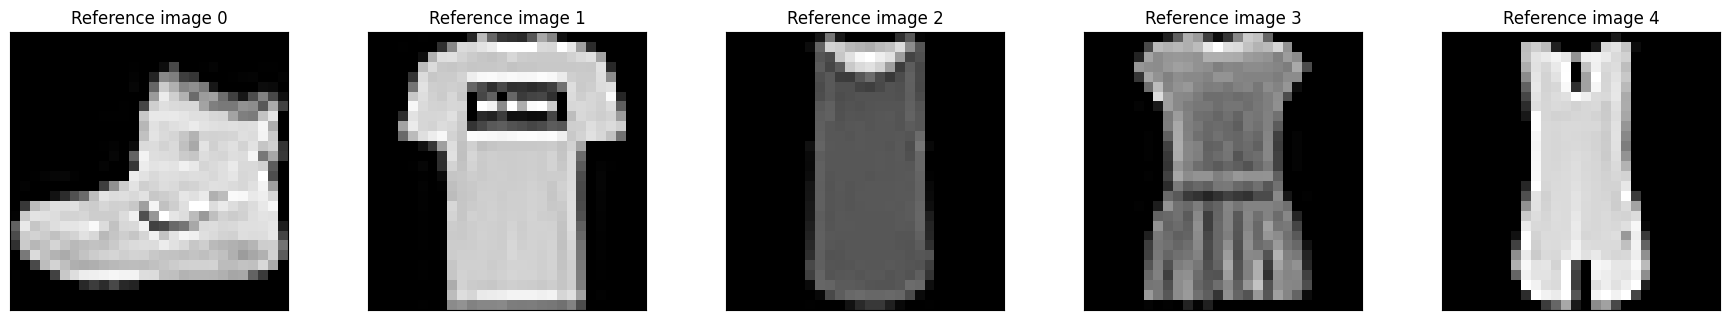

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3))
for i in range(5): 
    ax[i].imshow(x_train[i], cmap="grey")
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image {i}")
plt.tight_layout(pad=0.0)

In [8]:
plt.rcParams["figure.figsize"] = (4,3)

In [12]:
data_train = x_train[:10000, 1:, 1:]
data_test = x_test[:10000, 1:, 1:]

y_train = y_train[:10000]
y_test = y_test[:10000]

In [13]:
noises = [.0, .1, .2, .3, .4, .5]

noisy_test = [np.array([img + np.random.normal(.0, noise, size=(data_test[0].shape)) for img in data_test]) for noise in noises]
noisy_test_flattened = [data.reshape(-1, 27*27) for data in noisy_test]

train_flattened = data_train.reshape(-1, 27*27)

experiments = [
    "Baseline - no threshold",
    "Baseline - 0.7 threshold",
    "Baseline - 0.85 threshold",
    "Experiment 4 - only real filters",
    "Experiment 4 - with imaginary filters",
    "Experiment 6 - with imaginary filters",
    "Experiment 7 - with imaginary filters",
    "Experiment 8 - with imaginary filters"
]

#### Baseline - LR - No thresholding

In [14]:
scores_noisy_lr = []

In [15]:
clfs_bl = [LogisticRegression(fit_intercept=True,
                              multi_class='multinomial',
                              penalty='l2',
                              solver='saga',
                              max_iter=1000,
                              n_jobs=8,
                              tol=0.01) for _ in range(len(noises))]
baseline_lr_scores = score_clfs_noisy(clfs_bl, train_flattened, y_train, noisy_test_flattened, y_test)
scores_noisy_lr.append(baseline_lr_scores)
baseline_lr_scores

[0.8242, 0.8247, 0.8241, 0.824, 0.8244, 0.8242]

#### Baseline - LR - 0.7 thresholding

In [9]:
clfs_bl_threshold1 = [LogisticRegression(fit_intercept=True,
                                         multi_class='multinomial',
                                         penalty='l2',
                                         solver='saga',
                                         max_iter=1000,
                                         n_jobs=64,
                                         tol=0.01) for _ in range(len(noises))]

train_flattened_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
noisy_test_flattened_threshold1 = [np.where(n > 0.7, n, 0.) for n in noisy_test_flattened]

baseline_lr_scores_1 = score_clfs_noisy(clfs_bl_threshold1, 
                                        train_flattened_threshold1, 
                                        y_train, 
                                        noisy_test_flattened_threshold1, 
                                        y_test)

scores_noisy_lr.append(baseline_lr_scores_1)
baseline_lr_scores_1

[0.8402, 0.8397, 0.8403, 0.8402, 0.8408, 0.8399]

#### Baseline - LR - 0.85 thresholding

In [10]:
clfs_bl_threshold2 = [LogisticRegression(fit_intercept=True,
                                         multi_class='multinomial',
                                         penalty='l2',
                                         solver='saga',
                                         max_iter=1000,
                                         n_jobs=64,
                                         tol=0.01) for _ in range(len(noises))]

train_flattened_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
noisy_test_flattened_threshold2 = [np.where(n > 0.85, n, 0.) for n in noisy_test_flattened]

baseline_lr_scores_2 = score_clfs_noisy(clfs_bl_threshold2, 
                                        train_flattened_threshold2, 
                                        y_train, 
                                        noisy_test_flattened_threshold2, 
                                        y_test)

scores_noisy_lr.append(baseline_lr_scores_2)
baseline_lr_scores_2

[0.8403, 0.84, 0.8404, 0.8404, 0.8406, 0.8404]

#### Experiment 4 - Only real filters

In [11]:
exp_4_train_transformed = experiment4(data_train)
exp_4_test_transformed = [experiment4(test) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [12]:
clfs_lr_ex4 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp4_score = score_clfs_noisy(clfs_lr_ex4, exp_4_train_transformed, y_train, exp_4_test_transformed, y_test)
scores_noisy_lr.append(lr_noisy_exp4_score)
lr_noisy_exp4_score

[0.7933, 0.7932, 0.7935, 0.7917, 0.7894, 0.7865]

In [18]:
save_coefficients("train", exp_4_train_transformed, "experiment_4_train_fashoin_mnist")
[save_coefficients("test/experiment4", t, f"noise_test_{i}_fashion_mnist") for i, t in enumerate(exp_4_test_transformed)]

coefficients/train/experiment_4_train_fashoin_mnist.npy saved
coefficients/test/experiment4/noise_test_0_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_1_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_2_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_3_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_4_fashion_mnist.npy saved
coefficients/test/experiment4/noise_test_5_fashion_mnist.npy saved


[None, None, None, None, None, None]

#### Experiment 4 - With imaginary filters

In [16]:
exp_4_train_transformed_img = experiment4_img(data_train)
exp_4_test_transformed_img = [experiment4_img(test) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

IndexError: index 156 is out of bounds for axis 1 with size 156

In [ ]:
clfs_lr_ex4_img = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp4_score_img = score_clfs_noisy(clfs_lr_ex4_img, exp_4_train_transformed_img, y_train, exp_4_test_transformed_img, y_test)
scores_noisy_lr.append(lr_noisy_exp4_score_img)
lr_noisy_exp4_score_img

#### Experiment 6

In [17]:
exp_6_train_transformed_img = experiment6_img(data_train, threshold=0.85)
exp_6_test_transformed_img = [experiment6_img(test, threshold=0.85) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

IndexError: index 156 is out of bounds for axis 1 with size 156

In [ ]:
clfs_lr_ex6_img = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp6_score_img = score_clfs_noisy(clfs_lr_ex6_img, exp_6_train_transformed_img, y_train, exp_6_test_transformed_img, y_test)
scores_noisy_lr.append(lr_noisy_exp6_score_img)
lr_noisy_exp6_score_img

#### Experiment 7

In [ ]:
exp_7_train_transformed_img = experiment7_img(data_train)
exp_7_test_transformed_img = [experiment7_img(test) for test in noisy_test]

In [ ]:
clfs_lr_ex7_img = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp7_score_img = score_clfs_noisy(clfs_lr_ex7_img, exp_7_train_transformed_img, y_train, exp_7_test_transformed_img, y_test)
scores_noisy_lr.append(lr_noisy_exp7_score_img)
lr_noisy_exp7_score_img

#### Experiment 8

In [ ]:
exp_8_train_transformed_img = experiment8_img(data_train, threshold=0.85)
exp_8_test_transformed_img = [experiment8_img(test, threshold=0.85) for test in noisy_test]

In [ ]:
clfs_lr_ex8_img = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp8_score_img = score_clfs_noisy(clfs_lr_ex8_img, exp_8_train_transformed_img, y_train, exp_8_test_transformed_img, y_test)
scores_noisy_lr.append(lr_noisy_exp8_score_img)
lr_noisy_exp8_score_img

### SVM

In [ ]:
scores_noisy_svm = []

In [ ]:
clfs_svm_bl = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(noises))]
baseline_svm_scores = score_clfs_noisy(clfs_svm_bl, train_flattened, y_train, noisy_test_flattened, y_test)
scores_noisy_svm.append(baseline_svm_scores)
baseline_svm_scores

#### Baseline - SVM - 0.7 threshold

In [ ]:
clfs_svm_bl_thr1 = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(noises))]

train_flattened_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
noisy_test_flattened_threshold1 = [np.where(n > 0.7, n, 0.) for n in noisy_test_flattened]

baseline_svm_scores_thr1 = score_clfs_noisy(clfs_svm_bl_thr1, train_flattened_threshold1, y_train, noisy_test_flattened_threshold1, y_test)
scores_noisy_svm.append(baseline_svm_scores_thr1)
baseline_svm_scores_thr1

#### Baseline - SVM - 0.85 threshold

In [ ]:
clfs_svm_bl_thr2 = [SVC(kernel='rbf', C=10., gamma="auto") for _ in range(len(noises))]

train_flattened_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
noisy_test_flattened_threshold2 = [np.where(n > 0.85, n, 0.) for n in noisy_test_flattened]

baseline_svm_scores_thr2 = score_clfs_noisy(clfs_svm_bl_thr2, train_flattened_threshold2, y_train, noisy_test_flattened_threshold2, y_test)
scores_noisy_svm.append(baseline_svm_scores_thr2)
baseline_svm_scores_thr2

#### Experiment 4 - Only real filters

In [ ]:
clfs_svm_exp4 = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp4_svm = score_clfs_noisy(clfs_svm_exp4, exp_4_train_transformed, y_train, exp_4_test_transformed, y_test)
scores_noisy_svm.append(scores_noisy_exp4_svm)
scores_noisy_exp4_svm

#### Experiment 4 - With imaginary filters


In [ ]:
clfs_svm_exp4_img = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp4_svm_img = score_clfs_noisy(clfs_svm_exp4_img, exp_4_train_transformed_img, y_train, exp_4_test_transformed_img, y_test)
scores_noisy_svm.append(scores_noisy_exp4_svm_img)
scores_noisy_exp4_svm_img

#### Experiment 6

In [ ]:
clfs_svm_exp6_img = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp6_svm_img = score_clfs_noisy(clfs_svm_exp6_img, exp_6_train_transformed_img, y_train, exp_6_test_transformed_img, y_test)
scores_noisy_svm.append(scores_noisy_exp6_svm_img)
scores_noisy_exp6_svm_img

#### Experiment 7


In [ ]:
clfs_svm_exp7_img = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp7_svm_img = score_clfs_noisy(clfs_svm_exp7_img, exp_7_train_transformed_img, y_train, exp_7_test_transformed_img, y_test)
scores_noisy_svm.append(scores_noisy_exp7_svm_img)
scores_noisy_exp7_svm_img

#### Experiment 8

In [ ]:
clfs_svm_exp8_img = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp8_svm_img = score_clfs_noisy(clfs_svm_exp8_img, exp_8_train_transformed_img, y_train, exp_8_test_transformed_img, y_test)
scores_noisy_svm.append(scores_noisy_exp8_svm_img)
scores_noisy_exp8_svm_img

### KNN

In [ ]:
scores_noisy_knn = []

#### Baseline - KNN - No thresholding

In [ ]:
clfs_knn_bl = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores = score_clfs_noisy(clfs_knn_bl, train_flattened, y_train, noisy_test_flattened, y_test)
scores_noisy_knn.append(baseline_knn_scores)
baseline_knn_scores

#### Baseline - KNN - 0.7 thresholding

In [ ]:
clfs_knn_bl_thr1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr1 = score_clfs_noisy(clfs_knn_bl_thr1, train_flattened_threshold1, y_train, noisy_test_flattened_threshold1, y_test)
scores_noisy_knn.append(baseline_knn_scores_thr1)
baseline_knn_scores_thr1

#### Baseline - KNN - 0.85 thresholding

In [ ]:
clfs_knn_bl_thr2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr2 = score_clfs_noisy(clfs_knn_bl_thr2, train_flattened_threshold2, y_train, noisy_test_flattened_threshold2, y_test)
scores_noisy_knn.append(baseline_knn_scores_thr2)
baseline_knn_scores_thr2

#### Experiment 4 - Only real filters

In [ ]:
clfs_knn_exp4 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp4_knn = score_clfs_noisy(clfs_knn_exp4, exp_4_train_transformed, y_train, exp_4_test_transformed, y_test)
scores_noisy_knn.append(scores_noisy_exp4_knn)
scores_noisy_exp4_knn

#### Experiment 4 - With imaginary filters

In [ ]:
clfs_knn_exp4_img = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp4_knn_img = score_clfs_noisy(clfs_knn_exp4_img, exp_4_train_transformed_img, y_train, exp_4_test_transformed_img, y_test)
scores_noisy_knn.append(scores_noisy_exp4_knn_img)
scores_noisy_exp4_knn_img

#### Experiment 6

In [ ]:
clfs_knn_exp6_img = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp6_knn_img = score_clfs_noisy(clfs_knn_exp6_img, exp_6_train_transformed_img, y_train, exp_6_test_transformed_img, y_test)
scores_noisy_knn.append(scores_noisy_exp6_knn_img)
scores_noisy_exp6_knn_img

#### Experiment 7

In [ ]:
clfs_knn_exp7_img = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp7_knn_img = score_clfs_noisy(clfs_knn_exp7_img, exp_7_train_transformed_img, y_train, exp_7_test_transformed_img, y_test)
scores_noisy_knn.append(scores_noisy_exp7_knn_img)
scores_noisy_exp7_knn_img

#### Experiment 8

In [ ]:
clfs_knn_exp8_img = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp8_knn_img = score_clfs_noisy(clfs_knn_exp8_img, exp_8_train_transformed_img, y_train, exp_8_test_transformed_img, y_test)
scores_noisy_knn.append(scores_noisy_exp8_knn_img)
scores_noisy_exp8_knn_img